## General imports

In [26]:
# warning filters
import warnings
warnings.filterwarnings("ignore", message="Pandas requires version")
warnings.filterwarnings("ignore", message="A NumPy version >=")
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
warnings.filterwarnings("ignore", category=UserWarning, message="set_ticklabels\\(\\) should only be used with a fixed number of ticks")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib
# params = {'axes.titlesize':'18',
#           'xtick.labelsize':'16',
#           'ytick.labelsize':'16',
#           'font.size':'19',
#           'legend.fontsize':'medium',
#           'lines.linewidth':'2.5',
#           'font.weight':'normal',
#           'lines.markersize':'14',
#           'text.latex.preamble': r'\usepackage{amsfonts}',
#           'lines.markerfacecolor':'none'
#           }
# matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
markers = ['s', 'd', 'X', 'o', 'v', '*', '^', '8', 'h', '+']
import config_experiments as cfg

## Fixed parameters

In [27]:
# Define the metrics to plot
plot_metrics = ["MAD", "EOD", "SPD", "ALF", "ASF", "NCF", "ACC", "f1", "ROC_AUC"] # "PRD", "PED", "Precision", "Recall", 

# Define the anonymization methods
lst_methods = ['k-anonymity', 'l-diversity', 't-closeness']

# Define fixed values for parameters
lst_k = cfg.lst_k
l_div = cfg.l_div
lst_t = cfg.lst_t
lst_supp_level = cfg.supp_level
lst_fraction = cfg.lst_fraction
lst_deciles = cfg.lst_deciles

# Define datasets and sensitive attributes
lst_dataset = cfg.lst_dataset
lst_sensitive_attributes = cfg.lst_sensitive_attributes

## Plot main results

Dataset: adult Protected attribute: gender


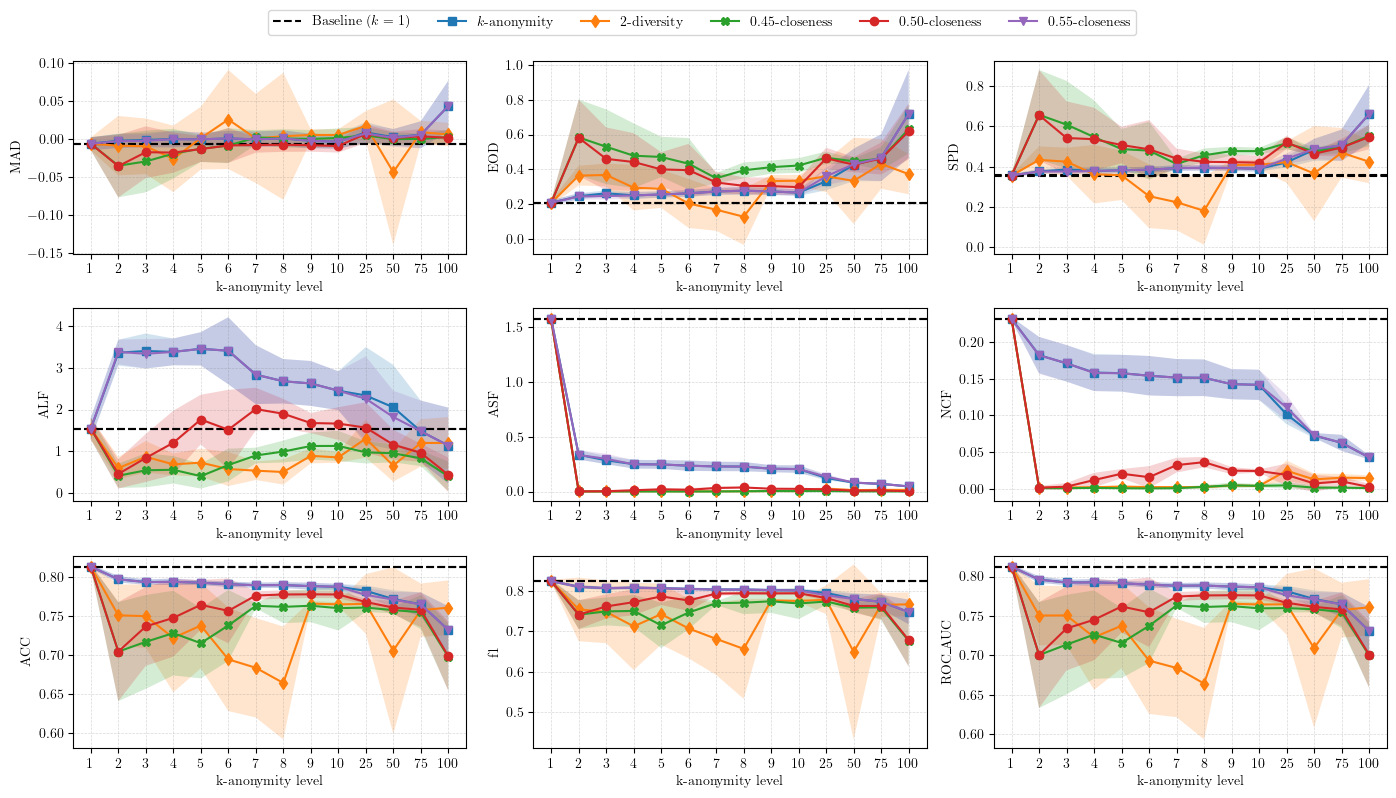


Dataset: adult Protected attribute: race


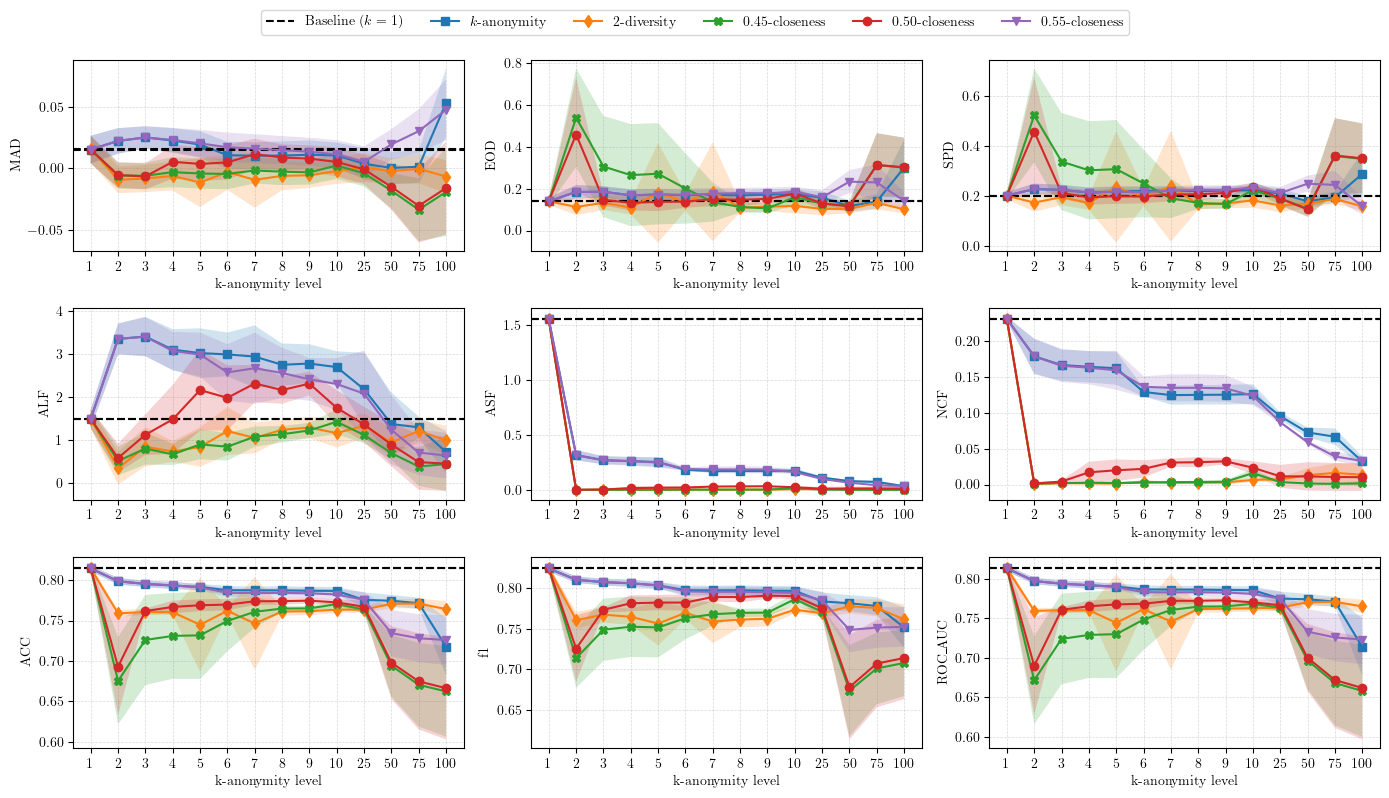


Dataset: ACSIncome Protected attribute: SEX


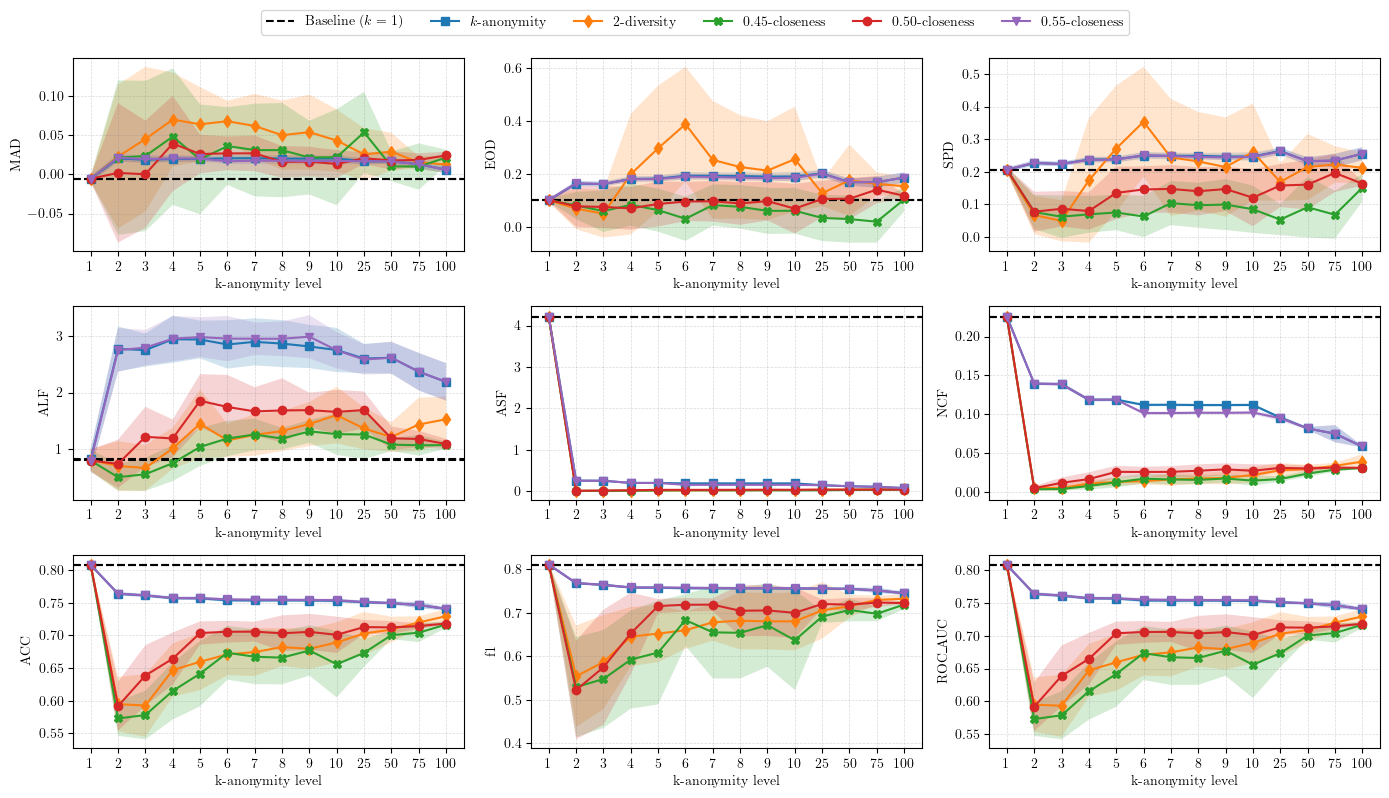


Dataset: ACSIncome Protected attribute: RAC1P


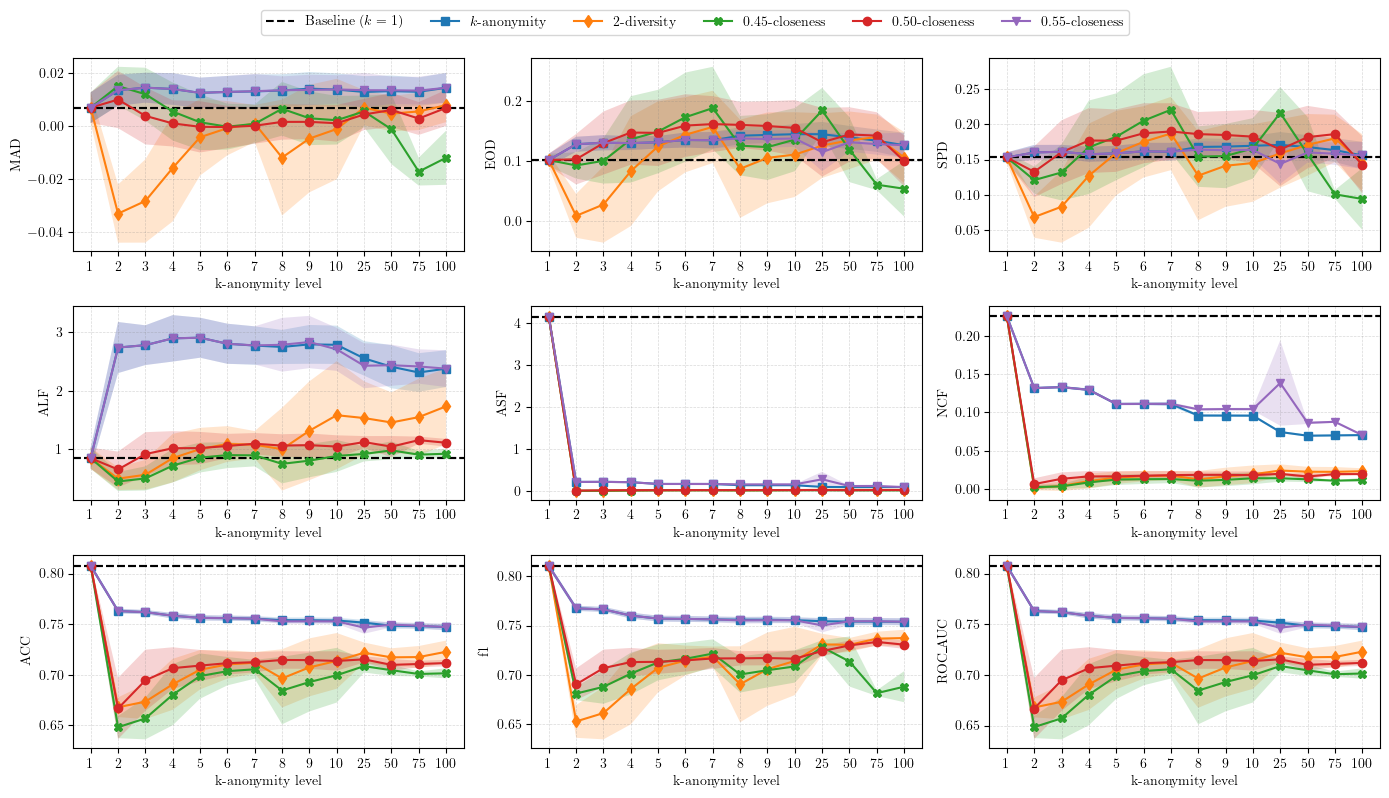

In [12]:
for dataset in lst_dataset:
    for protected_att in lst_sensitive_attributes[dataset]:

        print('Dataset:', dataset, 'Protected attribute:', protected_att)
        
        # Load dataset
        results_df = pd.read_csv("results/anonymity_impact_fairness_" + dataset + ".csv")

        # Collect handles and labels for the legend
        handles, labels = [], []
        legend_added = set()
        # Initialize plot
        plt.figure(figsize=(14, 8))

        for i, metric in enumerate(plot_metrics, 1):
            plt.subplot(3, 3, i)  # Arrange plots in a 2x5 grid
            plt.subplots_adjust(wspace=0.25, hspace=0.385)
            
            idx_marker = 0
            for method in lst_methods:
                if method == 'k-anonymity':
                    filtered_df = results_df[
                        (results_df['protected_att'] == protected_att) &
                        (results_df['method'] == 'k-anonymity') &
                        (results_df['k_parameter'].isin(lst_k))
                    ]
                    label = r'$k$-anonymity'
                
                elif method == 'l-diversity':
                    filtered_df = results_df[
                        (results_df['protected_att'] == protected_att) &
                        (results_df['method'] == 'l-diversity') &
                        (results_df['k_parameter'].isin(lst_k)) &
                        (results_df['anon_parameter'] == l_div)
                    ]
                    label = f'{l_div}-diversity'
                
                elif method == 't-closeness':
                    for t_val in lst_t:
                        filtered_df = results_df[
                            (results_df['protected_att'] == protected_att) &
                            (results_df['method'] == 't-closeness') &
                            (results_df['k_parameter'].isin(lst_k)) &
                            (results_df['anon_parameter'] == t_val)
                        ]

                        # Aggregate and plot for t_closeness
                        agg_results = filtered_df.groupby('k_parameter')[metric].agg(['mean', 'std']).reindex(lst_k).reset_index()
                        means = agg_results['mean']
                        stds = agg_results['std']
                        
                        # Only add to legend if not already added
                        if (method, t_val) not in legend_added:
                            line, = plt.plot(range(len(lst_k)), means, marker=markers[idx_marker], label=f'{float(t_val):.2f}-closeness')
                            legend_added.add((method, t_val))  # Mark as added to legend
                        else:
                            plt.plot(range(len(lst_k)), means, marker=markers[idx_marker])
                            
                        plt.fill_between(range(len(lst_k)), (means - stds).values, (means + stds).values, alpha=0.2)
                        idx_marker += 1
                    continue  # Skip to the next metric for t-closeness

                # Aggregate results for k-anonymity and l-diversity
                agg_results = filtered_df.groupby('k_parameter')[metric].agg(['mean', 'std']).reindex(lst_k).reset_index()
                means = agg_results['mean']
                stds = agg_results['std']

                # Add a horizontal line representing the baseline
                plt.axhline(y=means.iloc[0], color='black', linestyle='--', linewidth=1.5, label=r'Baseline ($k=1$)' if method == 'k-anonymity' and i == 1 else None) 
                
                # Plot mean and shaded area for standard deviation
                if (method, None) not in legend_added:
                    line, = plt.plot(range(len(lst_k)), means, marker=markers[idx_marker], label=label)
                    legend_added.add((method, None))  # Mark as added to legend
                else:
                    plt.plot(range(len(lst_k)), means, marker=markers[idx_marker])
                    
                plt.fill_between(range(len(lst_k)), (means - stds).values, (means + stds).values, alpha=0.2)
                idx_marker += 1

            # Set labels and title for each subplot
            #if i >= 6:
            plt.xlabel("k-anonymity level")
            plt.ylabel(metric)
            plt.grid(True, alpha=0.3, color='gray', linestyle='--', linewidth=0.5)
            plt.xticks(range(len(lst_k)), lst_k)

        # Add a single legend above all plots
        plt.figlegend(loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.0))

        # Adjust layout and display plot
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('results/fig_impact_anonymity_' + dataset + '_' + protected_att + '.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
        plt.show()
        print('=================================================================\n')


## Plot results suppression level

Dataset: adult Protected attribute: gender


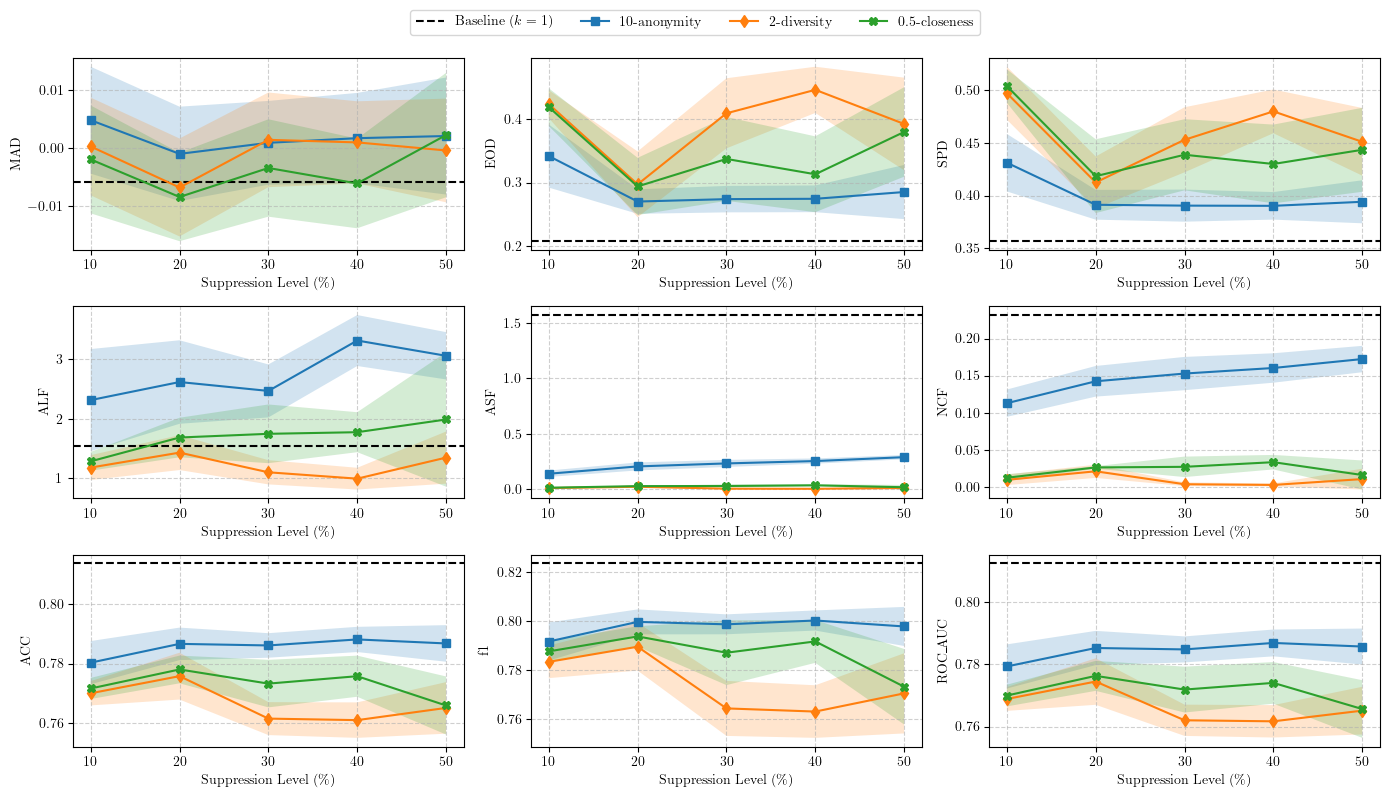

Dataset: adult Protected attribute: race


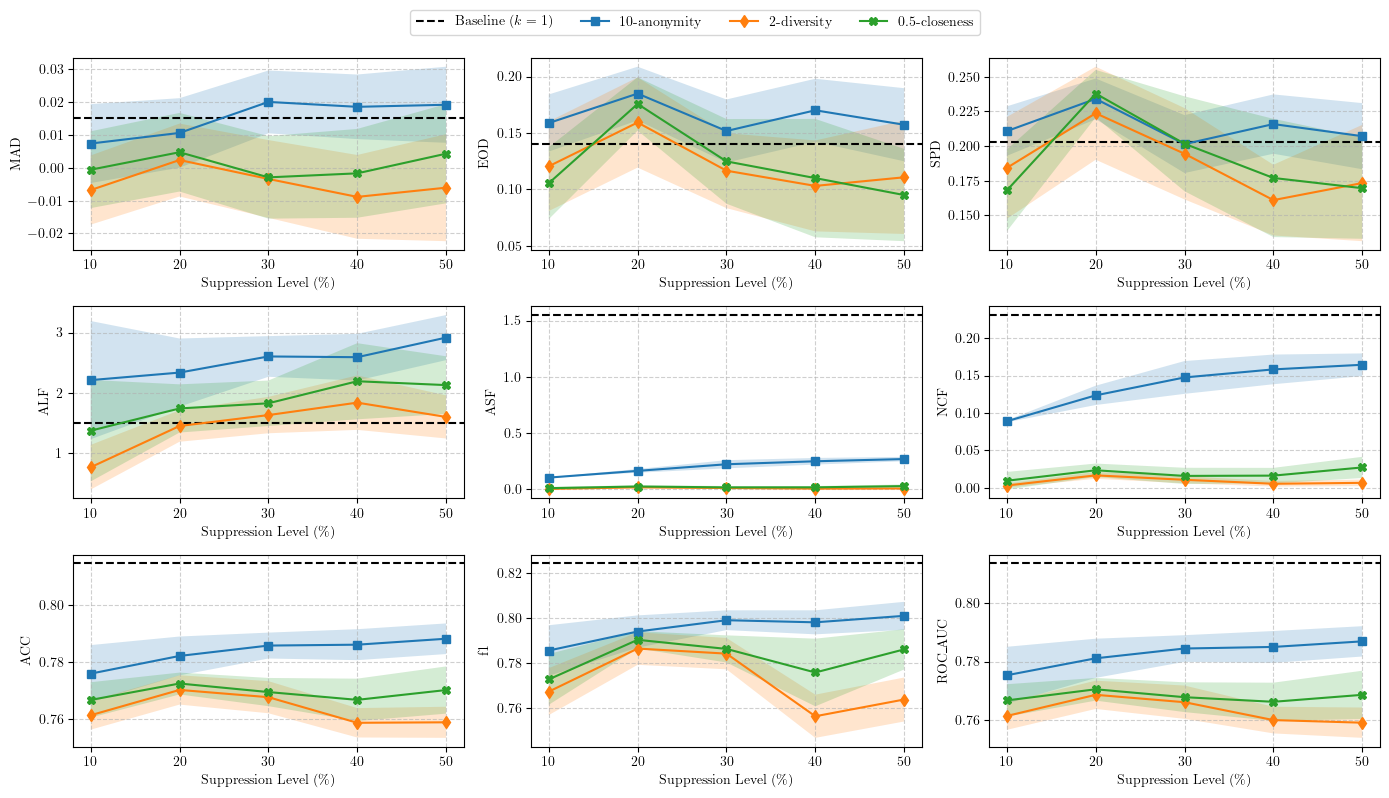

Dataset: ACSIncome Protected attribute: SEX


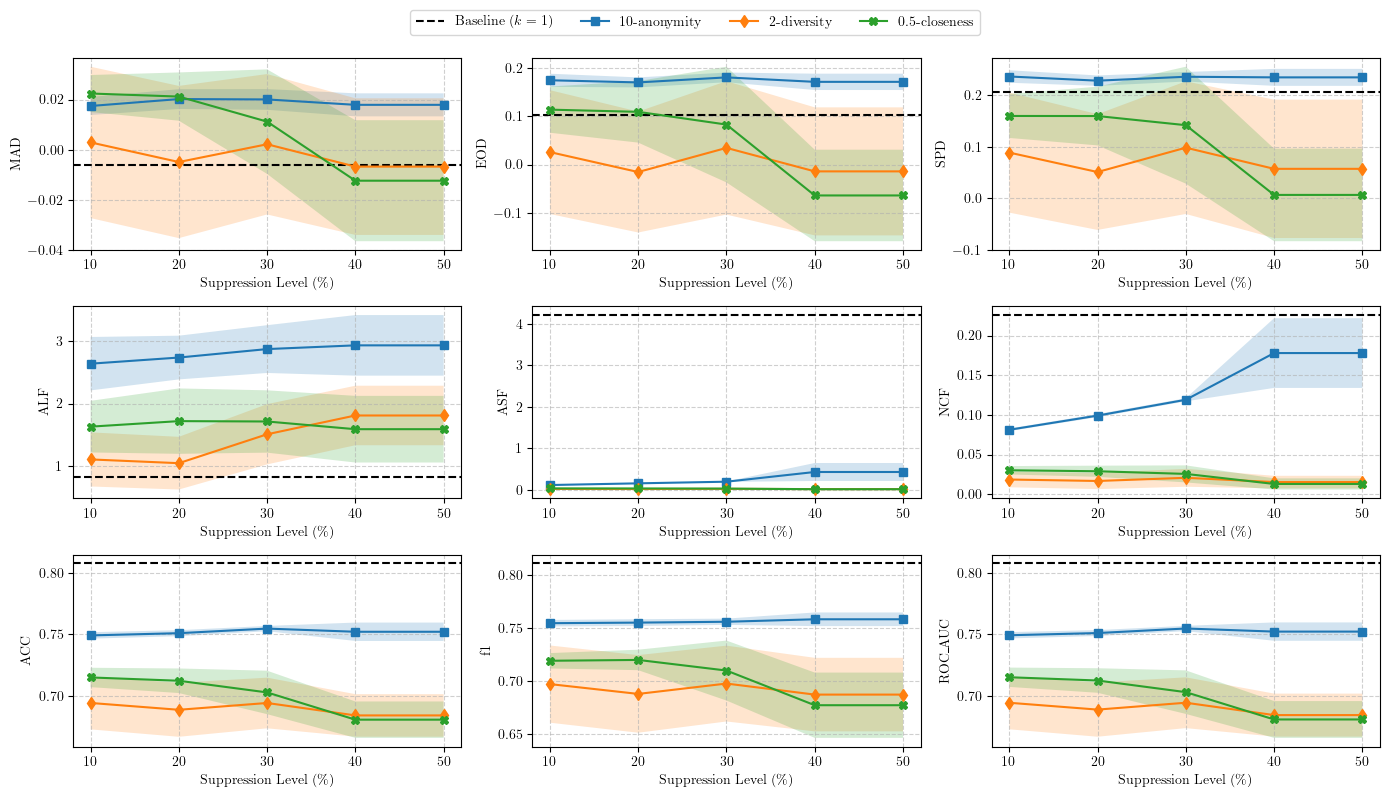

Dataset: ACSIncome Protected attribute: RAC1P


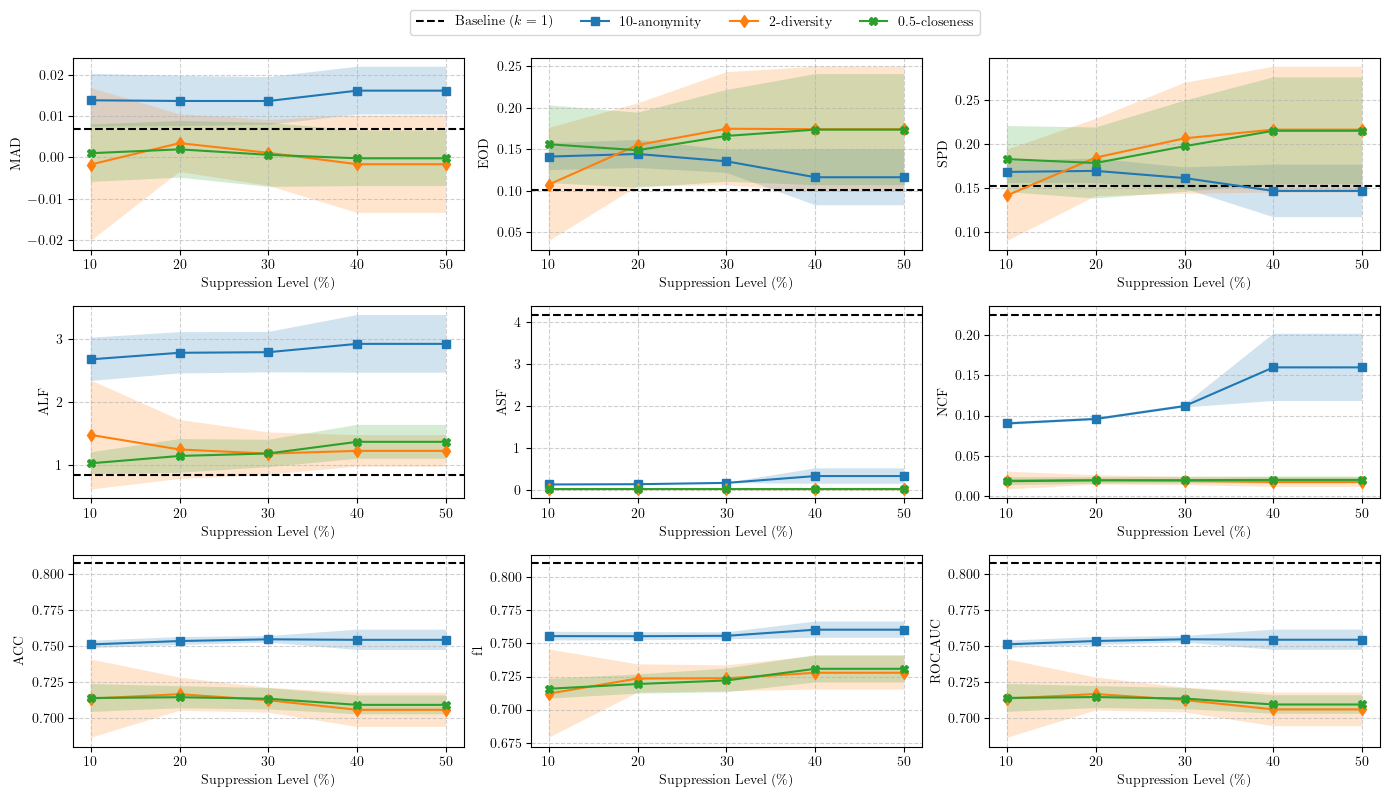

In [4]:
for dataset in lst_dataset:
    for protected_att in lst_sensitive_attributes[dataset]:

        print('Dataset:', dataset, 'Protected attribute:', protected_att)

        # Load datasets
        baseline_df = pd.read_csv("results/anonymity_impact_fairness_" + dataset + ".csv")
        results_df = pd.read_csv("results/anonymity_impact_fairness_suppression_" + dataset + ".csv")
        results_df = results_df.loc[results_df['protected_att'] == protected_att]

        # Create a figure for the aggregated plot
        fig, axes = plt.subplots(3, 3, figsize=(14, 8))  # Arrange plots in a 2x5 grid
        plt.subplots_adjust(wspace=0.25, hspace=0.35)

        # Flatten axes for easier indexing
        axes = axes.flatten()

        # Loop through metrics
        for idx, metric in enumerate(plot_metrics):
            ax = axes[idx]

            # plot non-private metric
            non_private_df = baseline_df[
                                        (baseline_df['protected_att'] == protected_att) &
                                        (baseline_df['method'] == 'k-anonymity') &
                                        (baseline_df['k_parameter'] == 1)]
            mean_baseline = non_private_df[metric].mean()
            ax.axhline(y=mean_baseline, color='black', linestyle='--', linewidth=1.5, label='Baseline' if idx == 0 else None) 

            # Loop through anonymization methods
            for method, marker in zip(lst_methods, markers):
                method_df = results_df[results_df['method'] == method]

                # Group by suppression level and compute mean and std for each metric
                agg_results = method_df.groupby('supp_level')[metric].agg(['mean', 'std']).reindex(lst_supp_level)
                means = agg_results['mean']
                stds = agg_results['std']

                # Plot with shaded area for standard deviation
                ax.plot(lst_supp_level, means, label=method,  marker=marker)
                ax.fill_between(lst_supp_level, (means - stds).values, (means + stds).values, alpha=0.2)
            
            # Customizing each subplot
            ax.set_ylabel(metric)
            ax.grid(True, linestyle='--', alpha=0.6)

        # Shared x-axis label
        for ax in axes:
            ax.set_xlabel(r"Suppression Level (\%)")
            ax.set_xticks(lst_supp_level)

        # Add a single legend for the entire figure
        fig.legend(
            handles=axes[0].get_legend_handles_labels()[0],  # Get handles from the first subplot
            labels = [r'Baseline ($k=1$)', f'{cfg.fixed_k}-anonymity', f'{cfg.fixed_l}-diversity', f'{cfg.fixed_t}-closeness'],
            loc="upper center", 
            ncol=4, 
            bbox_to_anchor=(0.5, 1.)
        )

        # Tight layout adjustment
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('results/fig_impact_suppression_level_' + dataset + '_' + protected_att + '.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
        plt.show()


## Plot data fraction results

Dataset: adult Protected attribute: gender


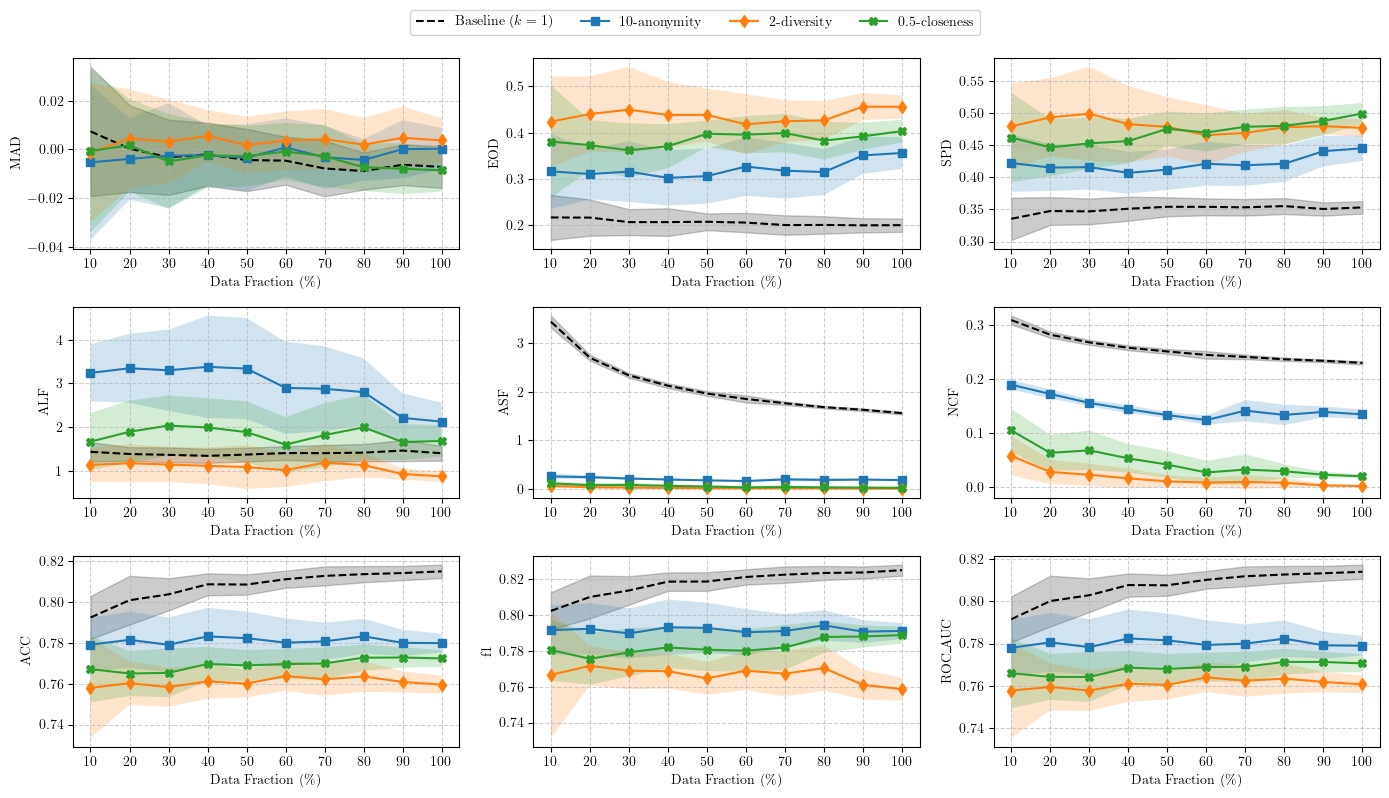

Dataset: adult Protected attribute: race


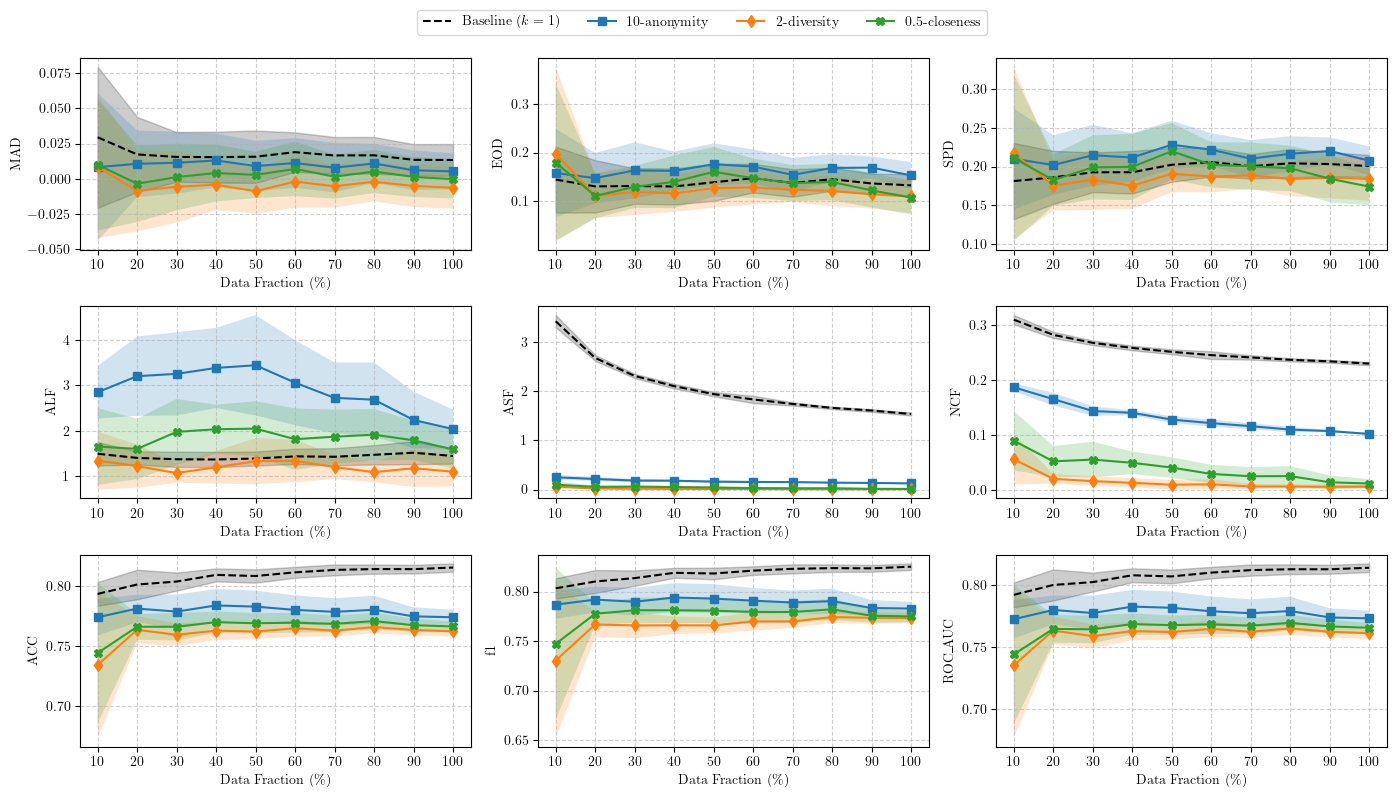

Dataset: ACSIncome Protected attribute: SEX


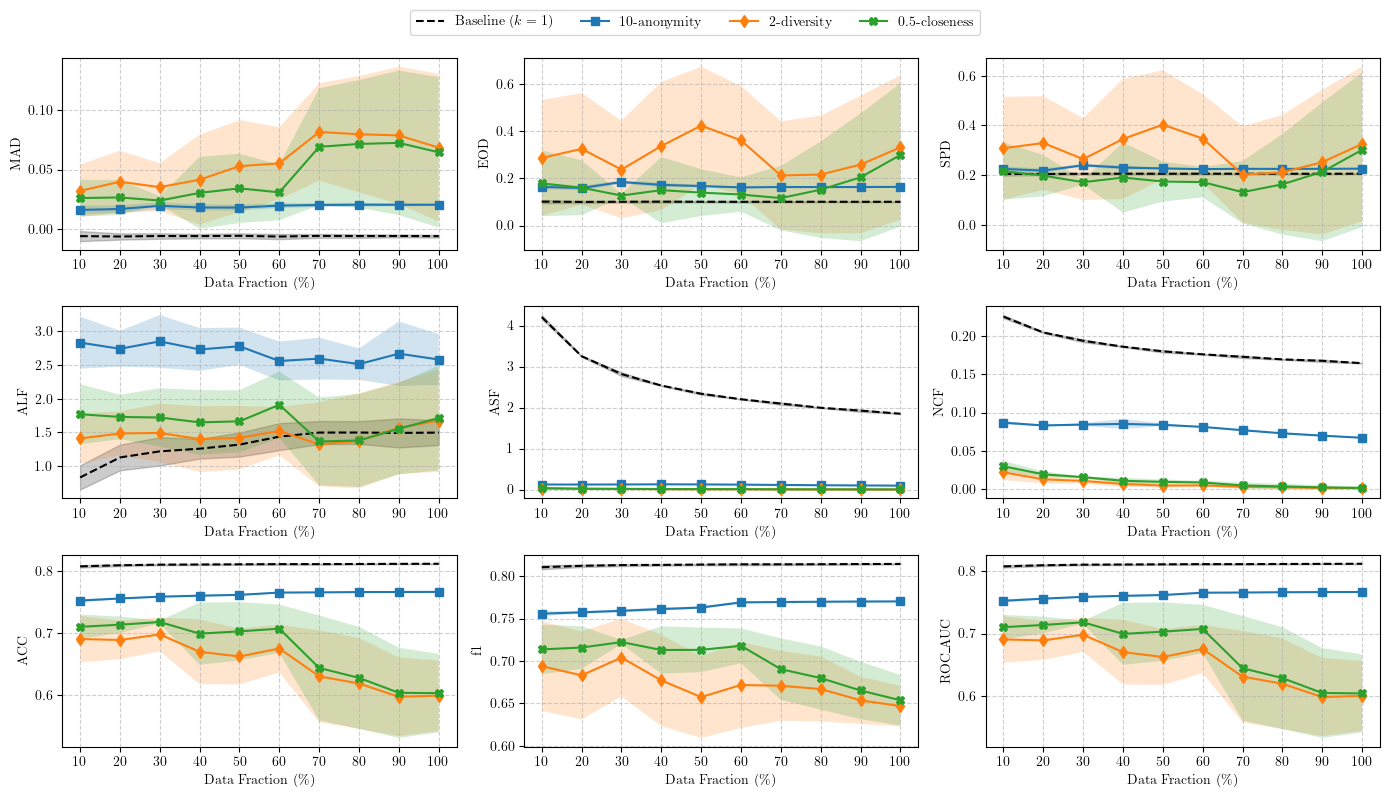

Dataset: ACSIncome Protected attribute: RAC1P


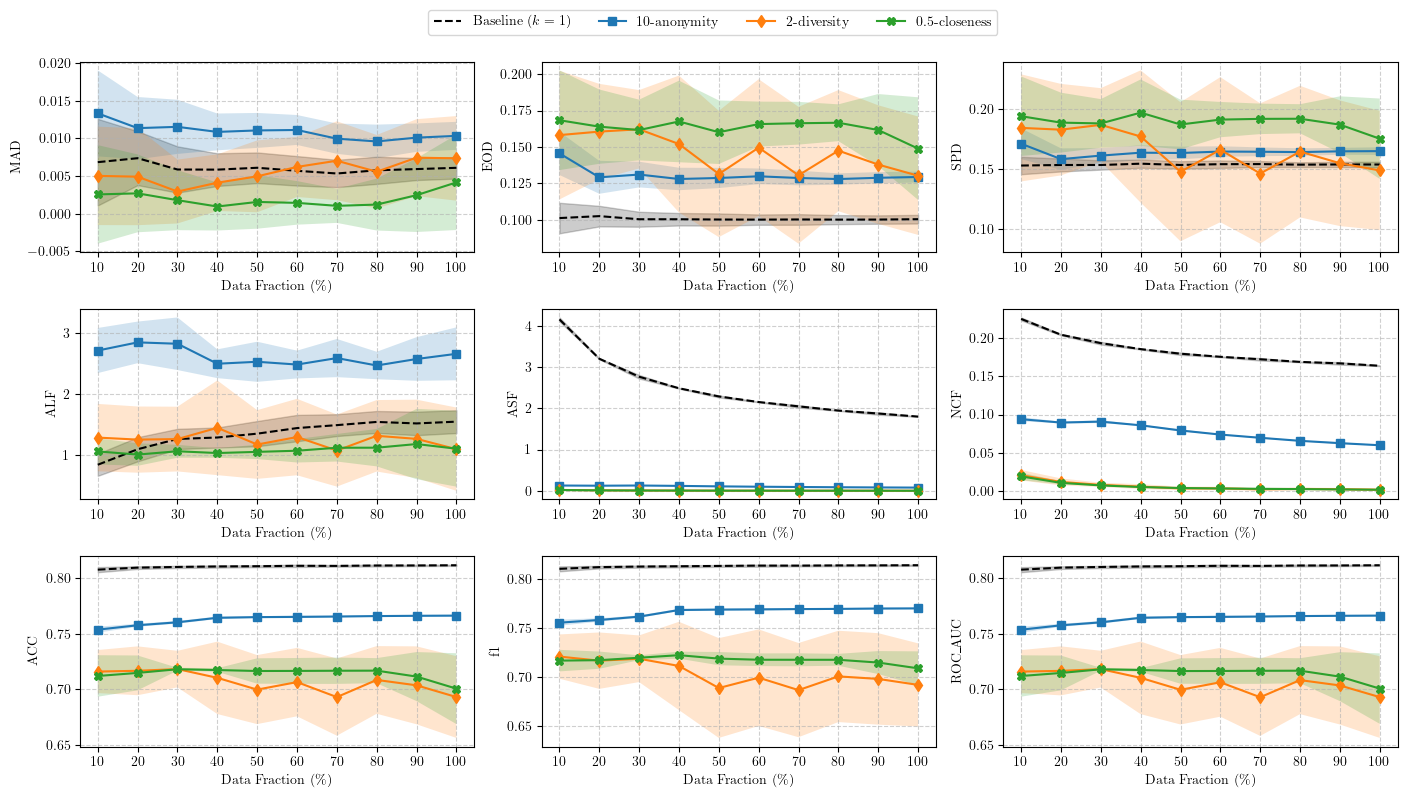

In [31]:
for dataset in lst_dataset:
    for protected_att in lst_sensitive_attributes[dataset]:

        print('Dataset:', dataset, 'Protected attribute:', protected_att)

        # Load dataset
        results_df = pd.read_csv("results/anonymity_impact_fairness_data_fraction_" + dataset + ".csv")
        results_df = results_df.loc[results_df['protected_att'] == protected_att]

        # Create a figure for the aggregated plot
        fig, axes = plt.subplots(3, 3, figsize=(14, 8))  # Arrange plots in a 2x5 grid
        plt.subplots_adjust(wspace=0.25, hspace=0.35)

        # Flatten axes for easier indexing
        axes = axes.flatten()

        # Loop through metrics
        for idx, metric in enumerate(plot_metrics):
            ax = axes[idx]
            
            # plot non-private metric
            non_private_df = results_df[(results_df['method'] == 'k-anonymity') & (results_df['anon_parameter'] == 1.0)]
            agg_baseline = non_private_df.groupby('fraction')[metric].agg(['mean', 'std']).reindex(lst_fraction)
            mean_baseline = agg_baseline['mean']
            std_baseline = agg_baseline['std']

            # Plot with shaded area for standard deviation
            ax.plot(lst_fraction, mean_baseline, color='black', linestyle='--', linewidth=1.5, label=r'Baseline ($k=1$)' if idx==0 else None)
            ax.fill_between(lst_fraction, (mean_baseline - std_baseline).values, (mean_baseline + std_baseline).values, alpha=0.2, color='black')

            # Loop through methods
            for method, marker in zip(lst_methods, markers):
                
                if method == 'k-anonymity':
                    method_df = results_df[(results_df['method'] == method) & (results_df['anon_parameter'] == cfg.fixed_k)]

                else:
                    method_df = results_df[results_df['method'] == method]

                # Group by suppression level and compute mean and std for each metric
                agg_results = method_df.groupby('fraction')[metric].agg(['mean', 'std']).reindex(lst_fraction)
                means = agg_results['mean']
                stds = agg_results['std']

                # Plot with shaded area for standard deviation
                ax.plot(lst_fraction, means, label=method,  marker=marker)
                ax.fill_between(lst_fraction, (means - stds).values, (means + stds).values, alpha=0.2)
            
            # Customizing each subplot
            ax.set_ylabel(metric)
            ax.grid(True, linestyle='--', alpha=0.6)

        # Shared x-axis label
        for ax in axes:
            ax.set_xlabel(r"Data Fraction (\%)")
            ax.set_xticks(lst_fraction)
            ax.set_xticklabels((np.array(lst_fraction)*100).astype(int))

        # Add a single legend for the entire figure
        fig.legend(
            handles=axes[0].get_legend_handles_labels()[0],  # Get handles from the first subplot
            labels = [r'Baseline ($k=1$)', f'{cfg.fixed_k}-anonymity', f'{cfg.fixed_l}-diversity', f'{cfg.fixed_t}-closeness'],
            loc="upper center", 
            ncol=4, 
            bbox_to_anchor=(0.5, 1.)
        )

        # Tight layout adjustment
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('results/fig_impact_data_fraction_' + dataset + '_' + protected_att + '.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
        plt.show()


## Plot target distribution results

Dataset: adult Protected attribute: gender


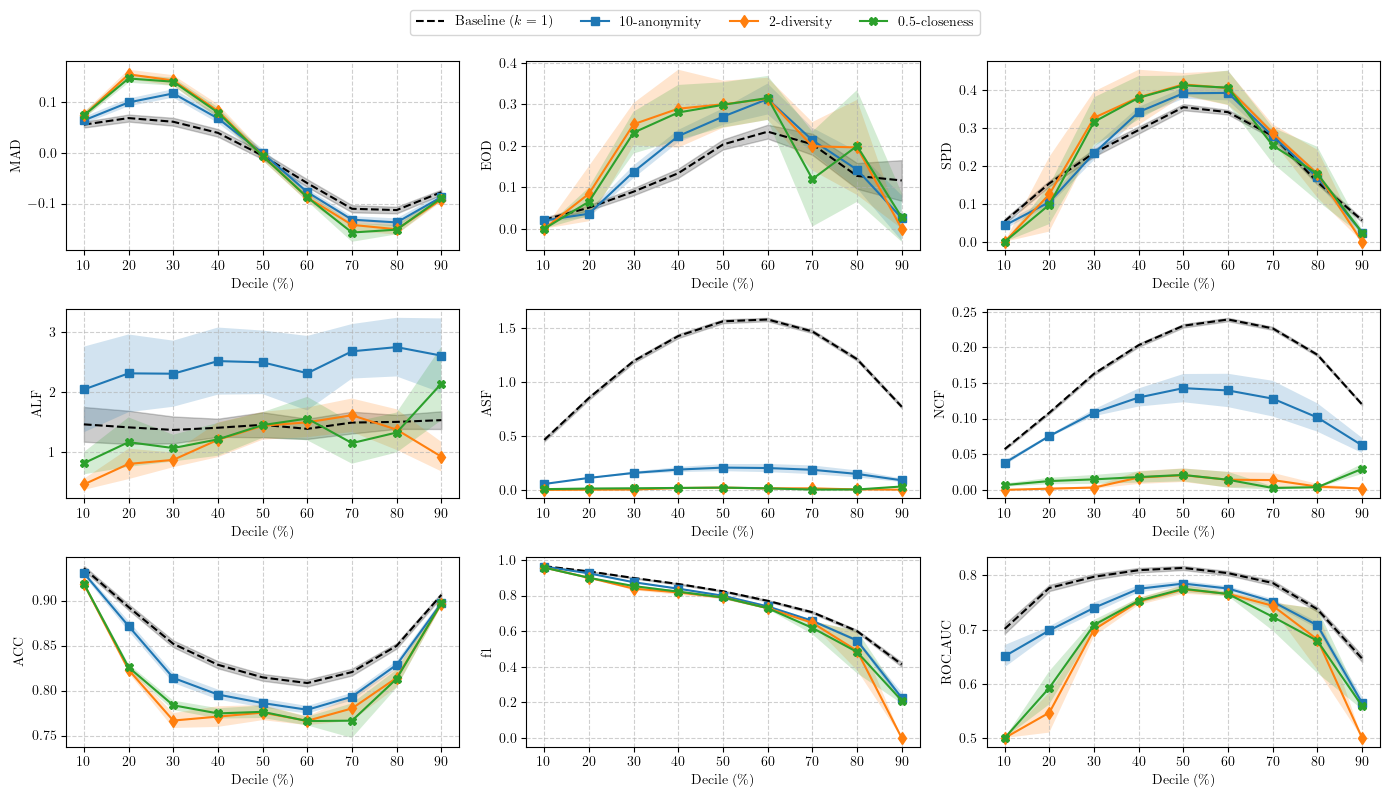

Dataset: adult Protected attribute: race


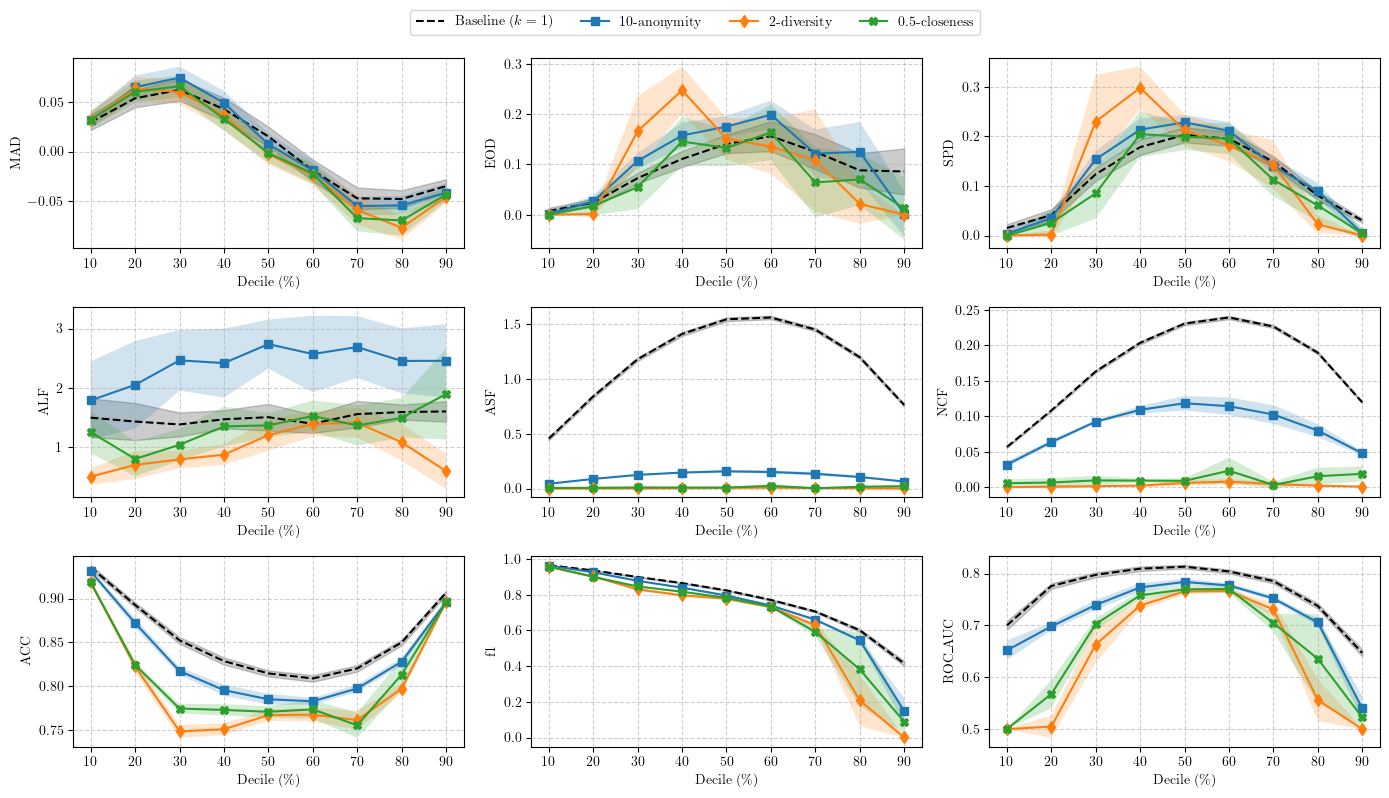

Dataset: ACSIncome Protected attribute: SEX


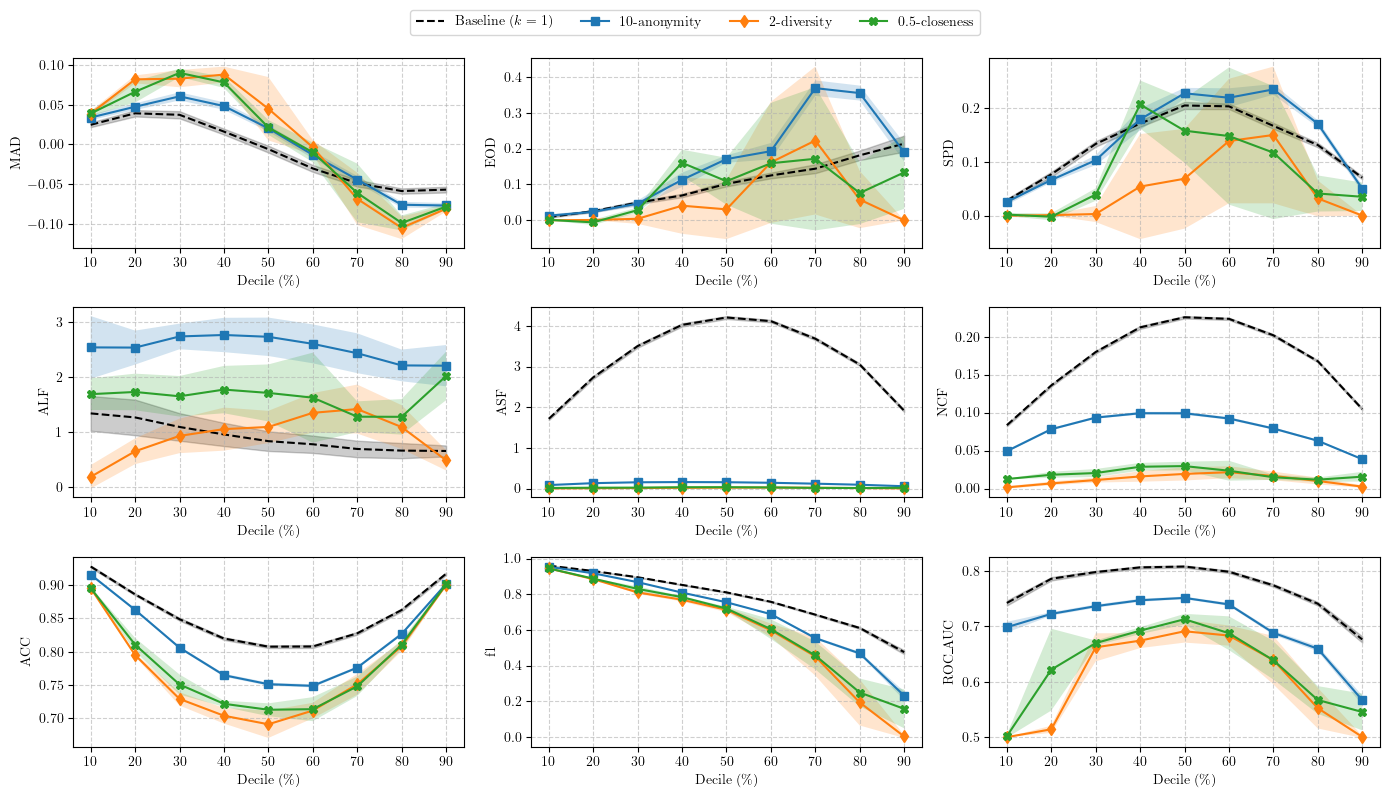

Dataset: ACSIncome Protected attribute: RAC1P


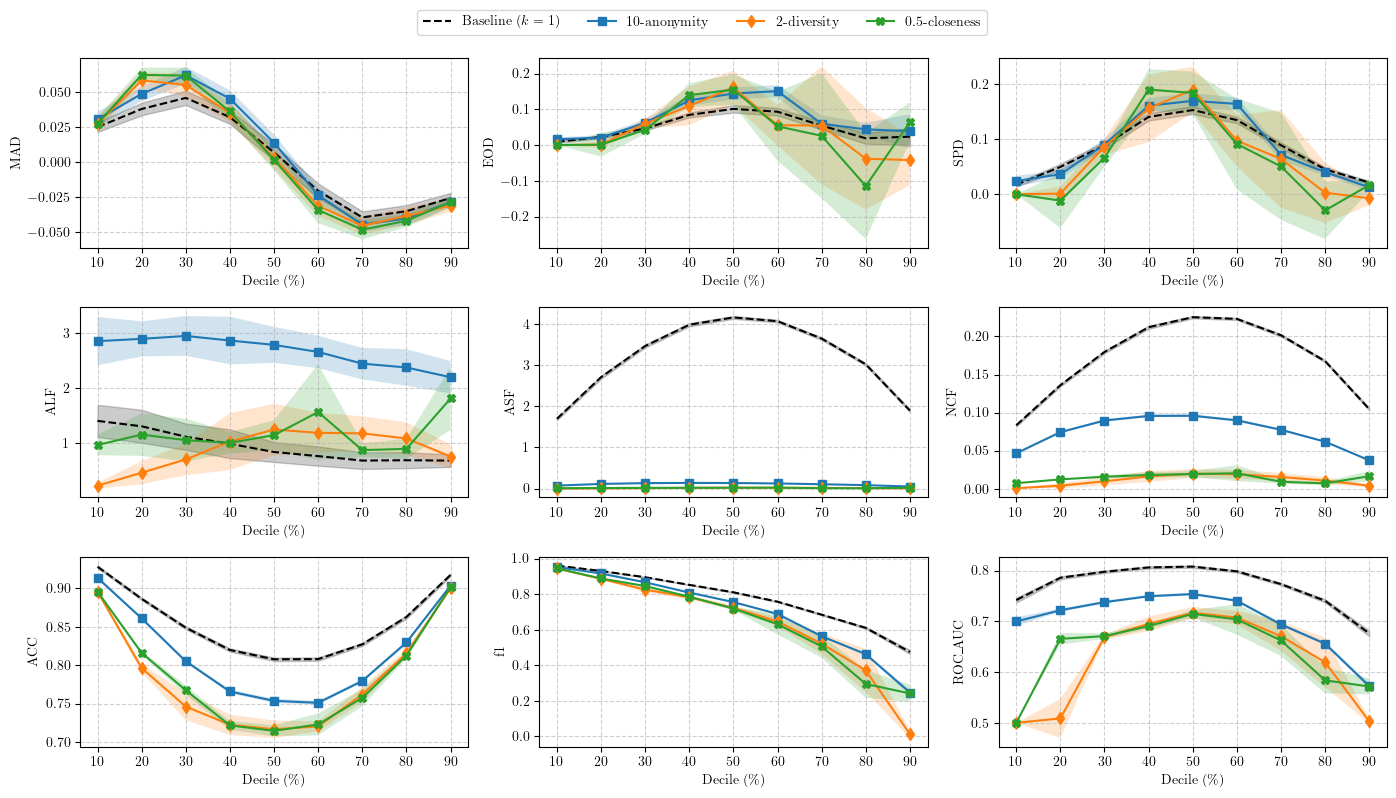

In [6]:
for dataset in lst_dataset:
    for protected_att in lst_sensitive_attributes[dataset]:

        print('Dataset:', dataset, 'Protected attribute:', protected_att)

        # Load dataset
        results_df = pd.read_csv("results/anonymity_impact_fairness_target_distribution_" + dataset + ".csv")
        results_df = results_df.loc[results_df['protected_att'] == protected_att]

        # Create a figure for the aggregated plot
        fig, axes = plt.subplots(3, 3, figsize=(14, 8))  # Arrange plots in a 2x5 grid
        plt.subplots_adjust(wspace=0.25, hspace=0.35)

        # Flatten axes for easier indexing
        axes = axes.flatten()

        # Loop through metrics
        for idx, metric in enumerate(plot_metrics):
            ax = axes[idx]
            
            # plot non-private metric
            non_private_df = results_df[(results_df['method'] == 'k-anonymity') & (results_df['anon_parameter'] == 1.0)]
            agg_baseline = non_private_df.groupby('threshold_target')[metric].agg(['mean', 'std'])
            mean_baseline = agg_baseline['mean']
            std_baseline = agg_baseline['std']

            # Plot with shaded area for standard deviation
            ax.plot(lst_deciles, mean_baseline.values, color='black', linestyle='--', linewidth=1.5, label='Baseline' if idx==0 else None)
            ax.fill_between(lst_deciles, (mean_baseline - std_baseline).values, (mean_baseline + std_baseline).values, alpha=0.2, color='black')

            # Loop through methods
            for method, marker in zip(lst_methods, markers):
                
                if method == 'k-anonymity':
                    method_df = results_df[(results_df['method'] == method) & (results_df['anon_parameter'] == cfg.fixed_k)]

                else:
                    method_df = results_df[results_df['method'] == method]

                # Group by suppression level and compute mean and std for each metric
                agg_results = method_df.groupby('threshold_target')[metric].agg(['mean', 'std'])
                means = agg_results['mean']
                stds = agg_results['std']

                # Plot with shaded area for standard deviation
                ax.plot(lst_deciles, means.values, label=method,  marker=marker)
                ax.fill_between(lst_deciles, (means - stds).values, (means + stds).values, alpha=0.2)
            
            # Customizing each subplot
            ax.set_ylabel(metric)
            ax.grid(True, linestyle='--', alpha=0.6)

        # Shared x-axis label
        for ax in axes:
            ax.set_xlabel(r"Decile (\%)")
            ax.set_xticks(lst_deciles)
            ax.set_xticklabels(lst_deciles)

        # Add a single legend for the entire figure
        fig.legend(
            handles=axes[0].get_legend_handles_labels()[0],  # Get handles from the first subplot
            labels = [r'Baseline ($k=1$)', f'{cfg.fixed_k}-anonymity', f'{cfg.fixed_l}-diversity', f'{cfg.fixed_t}-closeness'],
            loc="upper center", 
            ncol=4, 
            bbox_to_anchor=(0.5, 1.)
        )

        # Tight layout adjustment
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('results/fig_impact_target_distribution_' + dataset + '_' + protected_att + '.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
        plt.show()


## Plot classifier results

Dataset: adult Protected attribute: gender


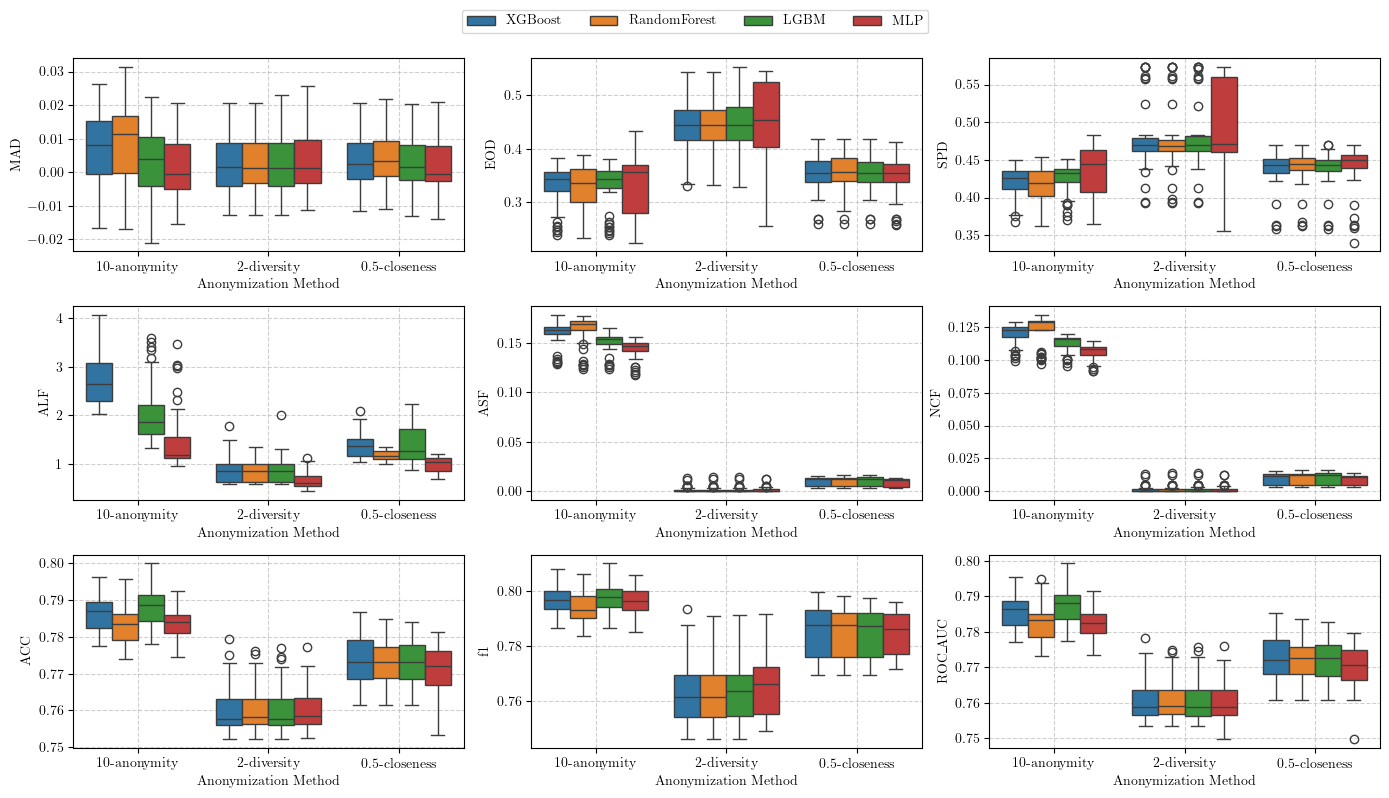

Dataset: adult Protected attribute: race


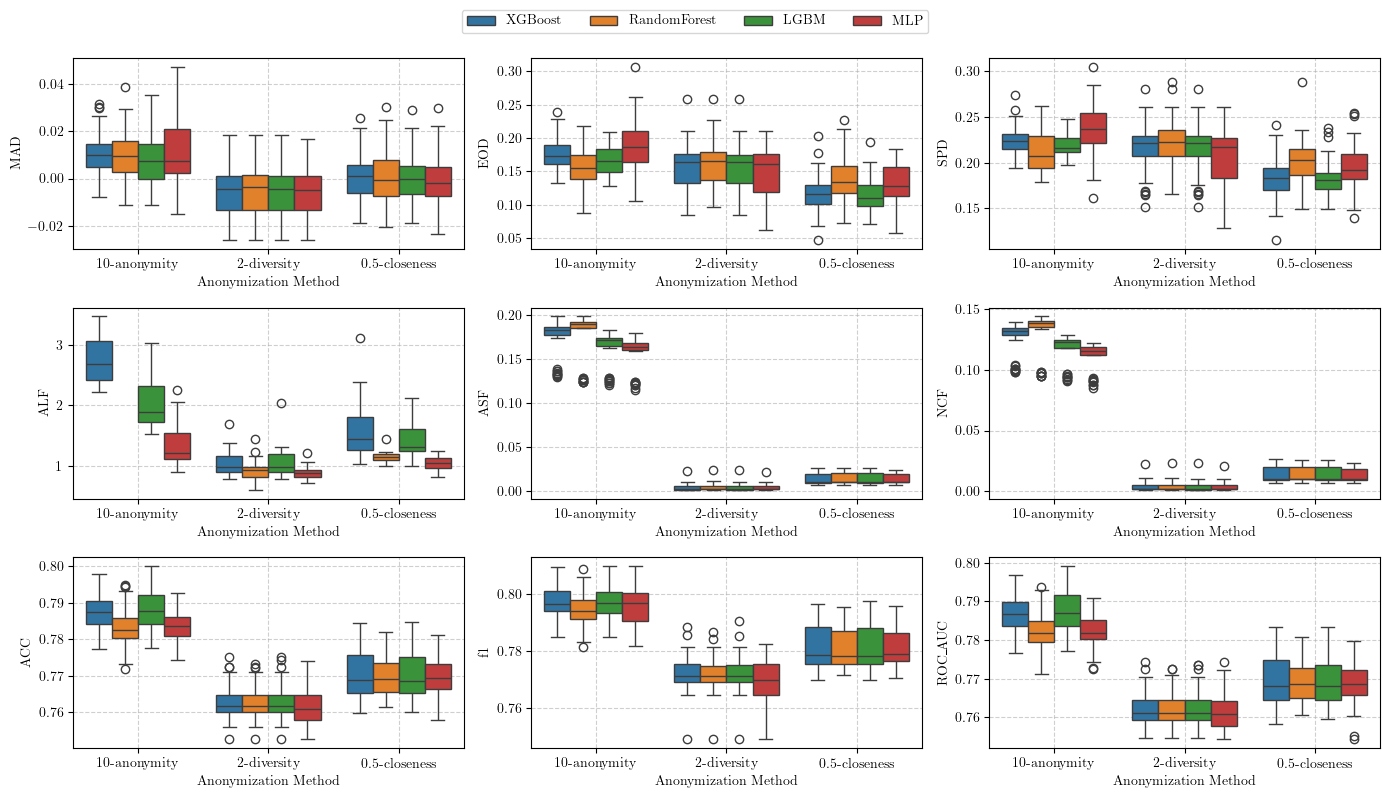

Dataset: ACSIncome Protected attribute: SEX


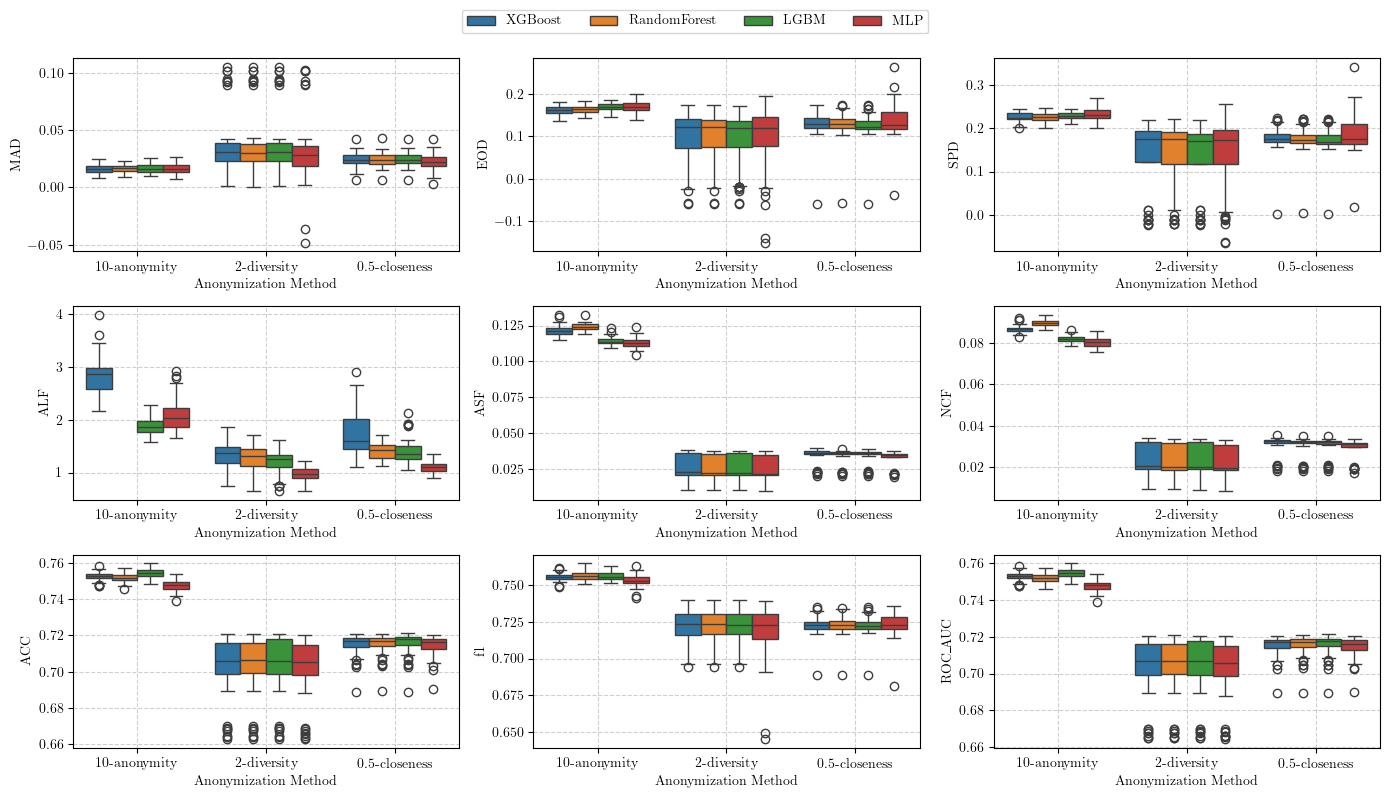

Dataset: ACSIncome Protected attribute: RAC1P


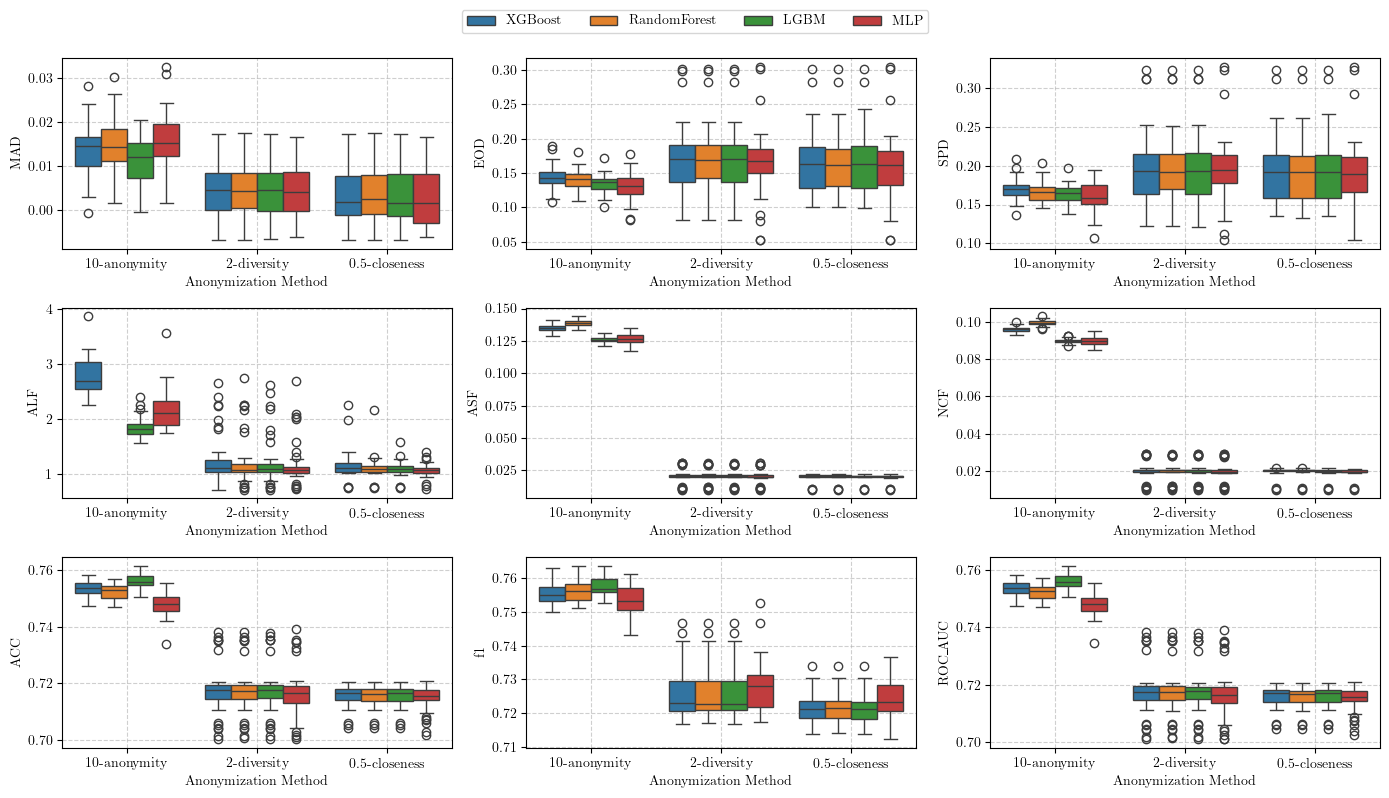

In [3]:
for dataset in cfg.lst_dataset:

    for protected_att in cfg.lst_sensitive_attributes[dataset]:
        print('Dataset:', dataset, 'Protected attribute:', protected_att)
        
        # Load the results from CSV
        results_df = pd.read_csv(f"results/anonymity_impact_fairness_classifier_{dataset}.csv")
        results_df = results_df.loc[results_df['protected_att'] == protected_att]
        results_df = results_df.loc[results_df['model_name'] != 'KNN']

        # Create a figure for the aggregated plot
        fig, axes = plt.subplots(3, 3, figsize=(14, 8))  # Arrange plots in a 2x5 grid
        plt.subplots_adjust(wspace=0.25, hspace=0.35)

        # Loop through each metric and create subplots
        for i, metric in enumerate(plot_metrics):
            row, col = divmod(i, 3)  # Determine row and column for the subplot
            ax = axes[row, col]
            
            # Create a grouped boxplot for the current metric
            sns.boxplot(
                x="method", 
                y=metric, 
                hue="model_name",  # Classifiers will be represented as different box plots within each anonymization method
                data=results_df, 
                ax=ax
            )
            
            # Customizing the plot
            ax.set_xlabel("Anonymization Method")
            ax.set_ylabel(metric)
            ax.set_xticklabels([f'{cfg.fixed_k}-anonymity', f'{cfg.fixed_l}-diversity', f'{cfg.fixed_t}-closeness'], rotation=0)
            ax.grid(True, linestyle='--', alpha=0.6)

        # Remove legends from individual subplots
        for ax in axes.flat:
            ax.legend_.remove()

        # Add a single legend on top
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(
            handles, 
            labels, 
            loc="upper center", 
            ncol=5,  
            bbox_to_anchor=(0.5, 1.)
        )

        # Adjust layout and display plot
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('results/fig_impact_classifier_' + dataset + '_' + protected_att + '.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
        plt.show()
